# All Ireland M.bovis strain diversity and clade identification

In [230]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
from Bio import SeqIO
import seaborn as sns
sys.path.append('pathogenie')
from snipgenie import tools, aligners, app, trees, plotting
path = '/storage/btbgenie/all_ireland_results'

## run NI

In [ ]:
reload(app)
args = {'threads':20, 'outdir': '/storage/btbgenie/NI_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/NI'],
         'species': 'Mbovis-AF212297',
         'overwrite':False,
         'custom_filters': True,       
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

## custom code to integrate previously aligned bam files together and call variants

This allows us to join previously mapped results together in one call without re-aligning

In [ ]:
#read in bam files
mapped = {'wicklow':'/storage/btbgenie/wicklow_results/mapped/',
                'monaghan':'/storage/btbgenie/monaghan/monaghan_results/mapped/',
                'NI':'/storage/btbgenie/NI_results/','UK':'/storage/btbgenie/UK_results/mapped'}
reload(app)
bam_files=[]
for m in mapped:
    f=app.get_files_from_paths(mapped[m], '*.bam')
    bam_files.extend(f)
print (len(bam_files))

outdir='/storage/btbgenie/all_ireland_results'
df = app.get_samples(bam_files,sep='_')
app.write_samples(df, outdir)

In [ ]:
#df.to_csv('/storage/btbgenie/mbovis_ireland/temp.csv',index=False)

## run rest of workflow as usual

In [ ]:
gff_file=os.path.join(outdir,'mbovis.gff')
tools.gff_bcftools_format(app.mbovis_gb, gff_file)
app.run_bamfiles(bam_files, app.mbovis_genome, outdir='/storage/btbgenie/all_ireland_results', threads=20,
                 mask=app.mbovis_mask, gff_file=gff_file,
                 custom_filters=True, overwrite=False)

In [ ]:
treefile = trees.run_RAXML(outfasta, bootstraps=100, outpath=outdir, threads=12)

## spoligotypes of all samples

In [ ]:
paths = {'Wicklow':'/storage/btbgenie/mbovis_ireland/Wicklow','Monaghan':'/storage/btbgenie/mbovis_ireland/Monaghan/',
         'NI':'/storage/btbgenie/mbovis_ireland/NI/'}
samples = []
for p in paths:
    f = app.get_files_from_paths(paths[p])   
    df = app.get_samples(f,sep='_')
    print (len(df['sample'].unique()))
    df=df.drop_duplicates('sample')   
    df['county'] = p   
    samples.append(df)

samples = pd.concat(samples)
#samples = samples.drop_duplicates(subset=['sample','county'])

In [ ]:
reload(tools)
res=[]
for i,r in samples.iterrows():    
    f=r.filename
    b = tools.get_spoligotype(f,1e6)
    sb = tools.get_sb_number(b)
    print (f, sb, b)
    res.append([f,sb,b])
    
res = pd.DataFrame(res,columns=['filename','SB','code'])
res.to_csv('/storage/btbgenie/all_ireland_results/spoligotypes.csv',index=False)

## get meta data

In [196]:
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv')
print (len(meta))

249


## clusters

In [268]:
def tree_clusts(f,dist):
    cmd = 'TreeCluster.py  -i {f} -t {d}'.format(f=f,d=dist)
    cl=subprocess.check_output(cmd, shell=True)
    cl=pd.read_csv(io.BytesIO(cl),sep='\t')
    return cl

res=pd.DataFrame()
for d in [0.045,0.02,0.01]:    
    cl = tree_clusts('%s/RAxML_bipartitions.variants' %path, d)
    res['name']=cl.SequenceName
    res[d] = cl.ClusterNumber

In [197]:
spo = pd.read_csv('/storage/btbgenie/all_ireland_results/spoligotypes.csv')
clust = pd.read_csv('/storage/btbgenie/all_ireland_results/clusters.txt',sep='\t')

In [198]:
meta = meta.merge(spo,on='sample')
meta = meta.merge(clust,left_on='sample',right_on='SequenceName')

## assign clade names?

In [209]:
clmap = {7:'NI-1',5:'Wicklow-1',4:'Monaghan-1',3:'Monaghan-2',6:'Monaghan-3',-1:'Unknown'}
meta['clade'] = meta.ClusterNumber.map(clmap)

In [269]:
meta

,name,sample,county,species,filename,pair,SB,code,SequenceName,ClusterNumber,clade,color
0,ERR125617,ERR125617,NI,Cow,/storage/btbgenie/mbovis_ireland/NI/ERR125617_...,1,SB0140,1.101101e+42,ERR125617,7,NI-1,blue
1,ERR125622,ERR125622,NI,Cow,/storage/btbgenie/mbovis_ireland/NI/ERR125622_...,1,SB0140,1.101101e+42,ERR125622,7,NI-1,blue
2,ERR125598,ERR125598,NI,Cow,/storage/btbgenie/mbovis_ireland/NI/ERR125598_...,1,SB0140,1.101101e+42,ERR125598,7,NI-1,blue
3,ERR125612,ERR125612,NI,Cow,/storage/btbgenie/mbovis_ireland/NI/ERR125612_...,1,SB0140,1.101101e+42,ERR125612,7,NI-1,blue
4,ERR125603,ERR125603,NI,Cow,/storage/btbgenie/mbovis_ireland/NI/ERR125603_...,1,SB0140,1.101101e+42,ERR125603,7,NI-1,blue
...,...,...,...,...,...,...,...,...,...,...,...,...
243,59-MBovis,59-MBovis,Wicklow,Cow,/storage/btbgenie/mbovis_ireland/Wicklow/Fastq...,1,SB0054,1.100101e+42,59-MBovis,5,Wicklow-1,green
244,7-10423,7-10423,Wicklow,Deer,/storage/btbgenie/mbovis_ireland/Wicklow/Fastq...,1,SB0054,1.100101e+42,7-10423,5,Wicklow-1,green
245,717,717,Monaghan,Badger,/storage/btbgenie/mbovis_ireland/Monaghan/Fast...,1,SB0142,1.101101e+42,717,6,Monaghan-3,crimson
246,724p,724p,Monaghan,Badger,/storage/btbgenie/mbovis_ireland/Monaghan/Fast...,1,SB0140,1.101101e+42,724p,3,Monaghan-2,burlywood


## draw trees

In [ ]:
reload(trees)
from ete3 import CircleFace, TreeStyle, NodeStyle, RectFace, TextFace
treefile = '/storage/btbgenie/all_ireland_results/RAxML_bipartitions.variants'

def make_tree():
    
    labelmap = dict(zip(meta['name'],meta.species))
    colormap = trees.colors_from_labels(meta,'name','county')
    t,ts = trees.create_tree(treefile, 'ref', colormap=colormap)  #labelmap=labelmap
    colors = {'wicklow': 'blue', 'monaghan': 'green','NI':'crimson'}
    for i in colors:
        f=ts.legend.add_face(
                TextFace(text=i,fgcolor=colors[i],fsize=28),            
                column=0)
    return t

t = make_tree()
ts=TreeStyle()
ts.scale=8000
t.render("%%inline",tree_style=ts,w=1000)

In [ ]:
t = make_tree()
#out = t.get_common_ancestor("19-4281", "19-2438", "461")
#out.delete()

In [ ]:
def color_clades(t):
    wick = t.get_common_ancestor("19-11957", "43-MBovis")
    mon = t.get_common_ancestor("19-7433", "19-6796")
    mon2 = t.get_common_ancestor("548", "2703")
    ni = t.get_common_ancestor("ERR125607","ERR125601")

    colors=['LightSteelBlue','lightgreen','lightgreen','salmon']
    for common,clr in zip([wick,mon,mon2,ni],colors):
        nodesinbranch = [node for node in common.traverse()]
        nstyle1=NodeStyle()
        nstyle1['bgcolor']=clr
        common.set_style(nstyle1)
        
color_clades(t)

In [ ]:
reload(trees)
ts=TreeStyle()
ts.scale=9000
ts.show_leaf_name = False
trees.set_nodesize(t, 40)
ts.mode = 'c'
t.render("%%inline",tree_style=ts,w=800)
#t.render("/storage/btbgenie/all_ireland.png",tree_style=ts,w=2000)

In [ ]:
samples.county.value_counts()
print (samples)

In [ ]:
colormap = trees.colors_from_labels(spo,'sample','SB')
labelmap = dict(zip(spo['sample'],spo.SB))
t,ts = trees.create_tree(treefile, 'ref')#, colormap=colormap, labelmap=labelmap)
color_clades(t)
trees.color_leaves(t, colormap)
trees.set_tiplabels(t,labelmap)
colors = {'wicklow': 'blue', 'monaghan': 'green','NI':'crimson'}
for i in colors:
       f=ts.legend.add_face(
             TextFace(text=i,fgcolor=colors[i],fsize=28),            
              column=0)

In [ ]:
ts.mode = 'c'
trees.set_nodesize(t, 10)
ts.scale=2000
t.render("%%inline",tree_style=ts,w=800)
#t.render("/storage/btbgenie/sb_tree.png",tree_style=ts,w=2000)

## toytree

In [266]:
import toytree
treefile = '/storage/btbgenie/all_ireland_results/RAxML_bipartitions.variants'
tre = toytree.tree(treefile)
tre = tre.root('ref')
tipnames = tre.get_tip_labels()
mapping = dict(zip(meta['sample'],meta.clade))
mapping['ref'] = 'AF2122/97'
tiplabels = [mapping[i] for i in tipnames]

mapping = dict(zip(meta['sample'],meta.ClusterNumber))
colormap = trees.colors_from_labels(meta,'name','ClusterNumber')
tip_colors = [colormap[mapping[i]] if i in mapping else 'Black' for i in tipnames]
tip_labels_style={      
        "font-size": "6px",
        "-toyplot-anchor-shift": "13px",
    }
node_sizes=[0 if i else 8 for i in tre.get_node_values(None, 1, 0)]
node_colors = [colormap[mapping[n]] if n in mapping else 'black' for n in tre.get_node_values('name', True, True)]

canvas,t,r=tre.draw(layout='r',width=800,height=1100,node_markers="o",node_hover=True, node_sizes=node_sizes,
                    tip_labels=tiplabels,tip_labels_style=tip_labels_style,node_colors=node_colors,
                    tip_labels_colors=tip_colors,scalebar=True,);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="1100.0px" viewBox="0 0 800.0 1100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tb036e170c61c4cdea61c297b6b1a30a1"> idx: 0
dist: 0.0000
support: 0.0000
height: 0.1679
name: 19-5224 idx: 1
dist: 0.0000
support: 0.0000
height: 0.1679
name: 19-5222 idx: 2
dist: 0.0005
support: 0.0000
height: 0.1674
name: 19-5221 idx: 3
dist: 0.0005
support: 0.0000
height: 0.1674
name: 19-3989 idx: 4
dist: 0.0005
support: 0.0000
height: 0.1674
name: 19-4872 idx: 5
dist: 0.0005
support: 0.0000
height: 0.1679
name: 19-3990 idx: 6
dist: 0.0000
support: 0.0000
height: 0.1684
name: 19-6468 idx: 7
dist: 0.0000
support: 0.0000
height: 0.1684
name: 19-7405 idx: 8
dist: 0.0000
support: 0.0000
height: 0.1684
name: 459p idx: 9
dist: 0.0000
support: 0.0000
height: 0.1679
name: 19-1426 idx: 10
dist: 0.0005
support: 0.0000
height: 0.1674
name: 19-4240 idx: 11
dist: 0.0076
support: 0.0000
height: 0.1603
name: 1579 idx: 12
dist: 0.0005
support: 0.0000
height: 0.1679
name: 3413 idx: 13
dist: 0.0000
support: 0.0000
height: 0.1679
name: 2606 idx: 14
dist: 0.0000
support: 0.0000
height: 0.1679
name: 2611 idx: 15
dist: 0.0000
support: 0.0000
height: 0.1679
name: 2608 idx: 16
dist: 0.0000
support: 0.0000
height: 0.1679
name: 1585 idx: 17
dist: 0.0005
support: 0.0000
height: 0.1674
name: 3480 idx: 18
dist: 0.0005
support: 0.0000
height: 0.1679
name: 2423p idx: 19
dist: 0.0005
support: 0.0000
height: 0.1689
name: 19-6357 idx: 20
dist: 0.0000
support: 0.0000
height: 0.1684
name: 19-1465 idx: 21
dist: 0.0000
support: 0.0000
height: 0.1684
name: 5158 idx: 22
dist: 0.0000
support: 0.0000
height: 0.1689
name: 3582 idx: 23
dist: 0.0000
support: 0.0000
height: 0.1689
name: 19-1690 idx: 24
dist: 0.0005
support: 0.0000
height: 0.1679
name: 19-1958 idx: 25
dist: 0.0005
support: 0.0000
height: 0.1679
name: 1953 idx: 26
dist: 0.0000
support: 0.0000
height: 0.1689
name: 717 idx: 27
dist: 0.0020
support: 0.0000
height: 0.1669
name: 19-4235 idx: 28
dist: 0.0000
support: 0.0000
height: 0.1689
name: 19-7464 idx: 29
dist: 0.0010
support: 0.0000
height: 0.1679
name: 19-2730 idx: 30
dist: 0.0020
support: 0.0000
height: 0.1699
name: 19-6656 idx: 31
dist: 0.0030
support: 0.0000
height: 0.1699
name: 1414 idx: 32
dist: 0.0056
support: 0.0000
height: 0.1684
name: 343 idx: 33
dist: 0.0066
support: 0.0000
height: 0.1674
name: 3495 idx: 34
dist: 0.0066
support: 0.0000
height: 0.1674
name: 2401 idx: 35
dist: 0.0010
support: 0.0000
height: 0.1689
name: 19-4161 idx: 36
dist: 0.0005
support: 0.0000
height: 0.1694
name: 4238 idx: 37
dist: 0.0010
support: 0.0000
height: 0.1689
name: 19-4165 idx: 38
dist: 0.0005
support: 0.0000
height: 0.1699
name: 2975 idx: 39
dist: 0.0000
support: 0.0000
height: 0.1704
name: 2977 idx: 40
dist: 0.0000
support: 0.0000
height: 0.1704
name: 2976 idx: 41
dist: 0.0000
support: 0.0000
height: 0.1704
name: 19-2600 idx: 42
dist: 0.0010
support: 0.0000
height: 0.1694
name: 3497 idx: 43
dist: 0.0000
support: 0.0000
height: 0.1709
name: 2347 idx: 44
dist: 0.0005
support: 0.0000
height: 0.1704
name: 19-1601 idx: 45
dist: 0.0005
support: 0.0000
height: 0.1709
name: 362p idx: 46
dist: 0.0010
support: 0.0000
height: 0.1704
name: 19-7404 idx: 47
dist: 0.0005
support: 0.0000
height: 0.1694
name: 19-6317 idx: 48
dist: 0.0010
support: 0.0000
height: 0.1689
name: 1147 idx: 49
dist: 0.0005
support: 0.0000
height: 0.1699
name: 1143 idx: 50
dist: 0.0000
support: 0.0000
height: 0.1704
name: 19-2786 idx: 51
dist: 0.0000
support: 0.0000
height: 0.1704
name: 19-7190 idx: 52
dist: 0.0000
support: 0.0000
height: 0.1689
name: 3437 idx: 53
dist: 0.0005
support: 0.0000
height: 

## SNP analysis

* snps unique to each clade/county
* protein groups containing common snps

In [276]:
csq = app.read_csq_file('/storage/btbgenie/all_ireland_results/csq.tsv')
snp_mat = app.get_aa_snp_matrix(csq)
#csq_ind = app.read_csq_file('/storage/btbgenie/all_ireland_results/csq_indels.tsv')
#ind_mat = app.get_aa_snp_matrix(csq_ind)

In [213]:
mat = snp_mat
#labelmap = dict(zip(meta['name'],meta.county))
#mat = mat.rename(columns=labelmap)
#freqs = mat.sum(1)/len(mat.columns)
#freqs =freqs.rename('freq') 
#freqs.sort_values()
#freqs.hist(bins=20)

In [214]:
#mat.index = mat.index.get_level_values(1)+'_'+mat.index.get_level_values(2)
stat = mat.sum(1).reset_index()
#stat.gene.value_counts()[:30]

In [277]:
cols=['name','county','SB','ClusterNumber','clade']
C=mat.T

C=C.merge(meta[cols],left_index=True,right_on='name').set_index(cols).T
#print (C)
C=C[C.sum(1)>3].T
C.iloc[:4,:2]
C.to_csv('csq_snps_ireland.csv')

/usr/local/lib/python3.8/dist-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [278]:
counties = list(C.index.get_level_values(1))
sb = list(C.index.get_level_values(2))
clust = C.index.get_level_values(3)
clades = C.index.get_level_values(4)

/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


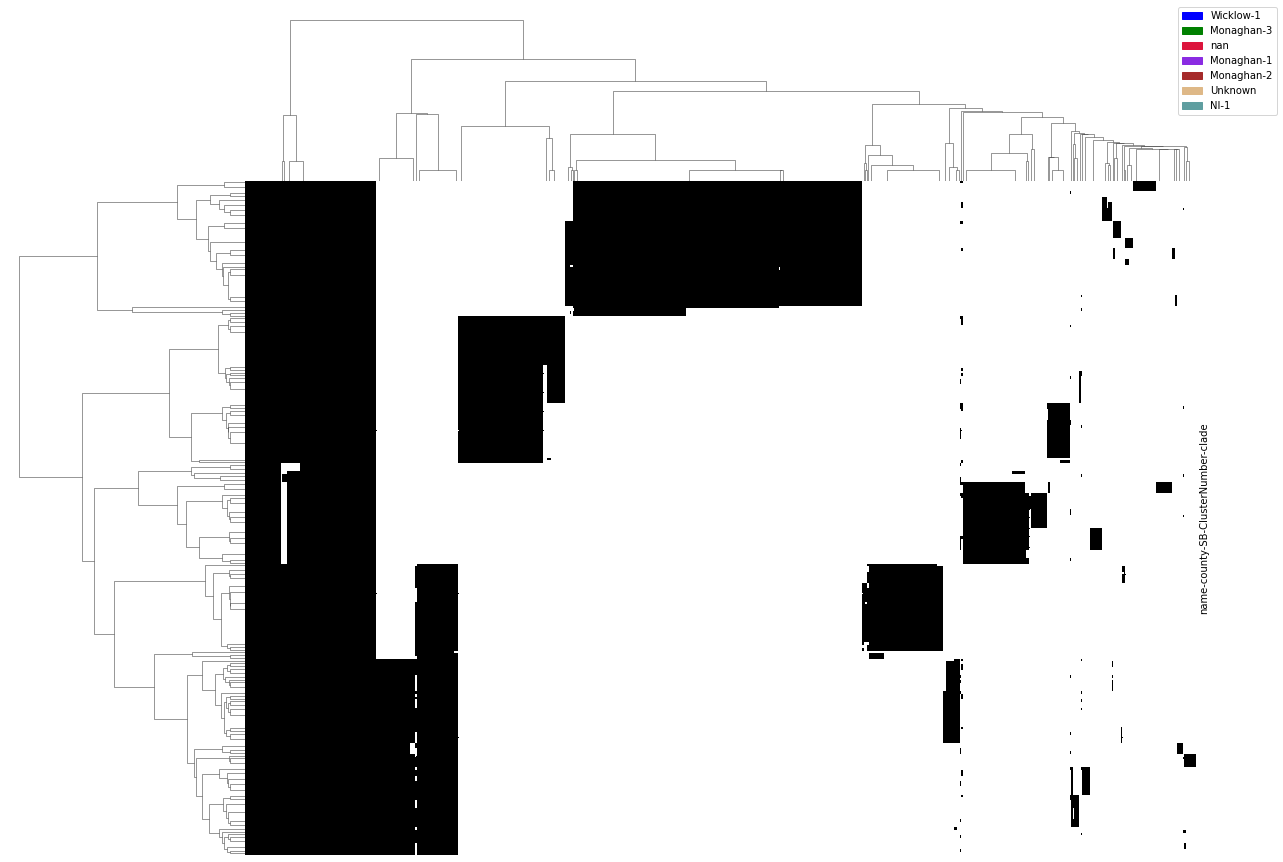

In [279]:
colormap1 = dict(zip(clades.unique(), trees.qcolors))
colors1 = [colormap1[i] if i in colormap else 'Black' for i in clades]
#make legend
import matplotlib.patches as mpatches
pts=[]
for c in colormap1:
    pts.append(mpatches.Patch(color=colormap1[c],label=c))
g=sns.clustermap(C,xticklabels=False,yticklabels=False,figsize=(17,12),cmap='gray_r',cbar_pos=None,row_colors=colors1)
g.fig.legend(handles=pts,bbox_to_anchor=(1.05, 1), )
g.savefig('/storage/btbgenie/all_ireland_results/snp_clusters.jpg')

## PCA

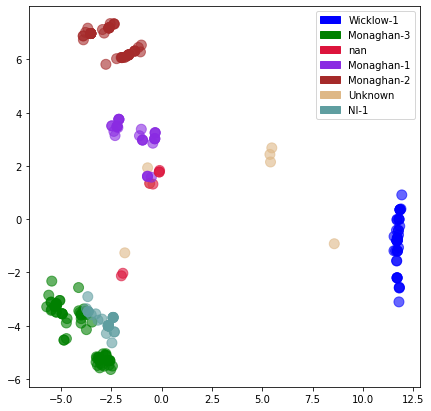

In [228]:
import sklearn
from sklearn import decomposition
from sklearn import manifold

pca = decomposition.PCA(n_components=3)
mds = manifold.MDS(n_components=3)
pos = mds.fit(C).embedding_
X = pca.fit_transform(pos)
#X = pca.transform(C)
df=pd.DataFrame(X)
df['sb']=sb
df.to_csv('/storage/btbgenie/all_ireland_results/pca_snp.csv')

fig,ax = plt.subplots(figsize=(7, 7))
sc=ax.scatter(X[:, 0], X[:, 1], c=colors1, s=100, alpha=.6)    
ax.legend(handles=pts,loc='best')
fig.savefig('/storage/btbgenie/all_ireland_results/pca_snp_clusters.jpg',dpi=150)